# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score,silhouette_samples

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

# 3. Data Engineering

## 3.1 Generate new Columns

In [6]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [7]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

### 3.1.1 Get Latest Order Date

In [8]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')


In [17]:
max_order_ts.agg(F.max(F.col('ORDER_TS'))).show()

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:59:57  |
-----------------------



## Before vs After Conversion

In [9]:
us_Orders=orders_with_rank.filter(F.col('COUNTRY')=='United States')

In [10]:
bef_Conv=us_Orders.filter(F.col('DATE')<F.col('SIGN_UP_DATE'))
aft_Conv=us_Orders.filter(F.col('DATE')>=F.col('SIGN_UP_DATE'))

In [11]:
# Define a window partitioned by customer and ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the next order for each customer
bef_Conv_orders_df = bef_Conv.withColumn("DAYS_TO_NEXT_ORDER", F.lead("DATE").over(window_spec))

# Calculate the number of days between the current order and the next order
bef_Conv_orders_df= bef_Conv_orders_df.withColumn("DAYS_TO_NEXT_ORDER", F.datediff(col1="DATE", col2="DAYS_TO_NEXT_ORDER",part='day'))

#Remove null values in target variable
bef_Conv_orders_df= bef_Conv_orders_df.na.drop(subset=["DAYS_TO_NEXT_ORDER"])

In [12]:
# Define a window partitioned by customer and ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the next order for each customer
aft_Conv_orders_df = aft_Conv.withColumn("DAYS_TO_NEXT_ORDER", F.lead("DATE").over(window_spec))

# Calculate the number of days between the current order and the next order
aft_Conv_orders_df= aft_Conv_orders_df.withColumn("DAYS_TO_NEXT_ORDER", F.datediff(col1="DATE", col2="DAYS_TO_NEXT_ORDER",part='day'))

#Remove null values in target variable
aft_Conv_orders_df= aft_Conv_orders_df.na.drop(subset=["DAYS_TO_NEXT_ORDER"])

In [13]:
bef_Conv_analysis=bef_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.avg(F.col('DAYS_TO_NEXT_ORDER')).alias('BEF_AVG_DAYS_TO_NEXT_ORDER'))

bef_Conv_analysis=bef_Conv_analysis.join(
    right=bef_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.count('*').alias('BEF_NUM_OF_ORDERS')),
    on="CUSTOMER_ID",
    how="inner"
)

bef_Conv_analysis=bef_Conv_analysis.join(
    right=bef_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.avg('ORDER_TOTAL').alias('BEF_AVERAGE_SPENDING')),
    on="CUSTOMER_ID",
    how="inner"
)

# bef_Conv_analysis.show()

In [14]:
aft_Conv_analysis=aft_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.avg(F.col('DAYS_TO_NEXT_ORDER')).alias('AFT_AVG_DAYS_TO_NEXT_ORDER'))

aft_Conv_analysis=aft_Conv_analysis.join(
    right=aft_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.count('*').alias('AFT_NUM_OF_ORDERS')),
    on="CUSTOMER_ID",
    how="inner"
)

aft_Conv_analysis=aft_Conv_analysis.join(
    right=aft_Conv_orders_df.group_by('CUSTOMER_ID').agg(F.avg('ORDER_TOTAL').alias('AFT_AVERAGE_SPENDING')),
    on="CUSTOMER_ID",
    how="inner"
)

# aft_Conv_analysis.show()

In [15]:
conv_Analysis=bef_Conv_analysis.join(
    right=aft_Conv_analysis,
    on="CUSTOMER_ID",
    how="inner"
)


In [16]:
conv_Analysis_df=conv_Analysis.to_pandas()

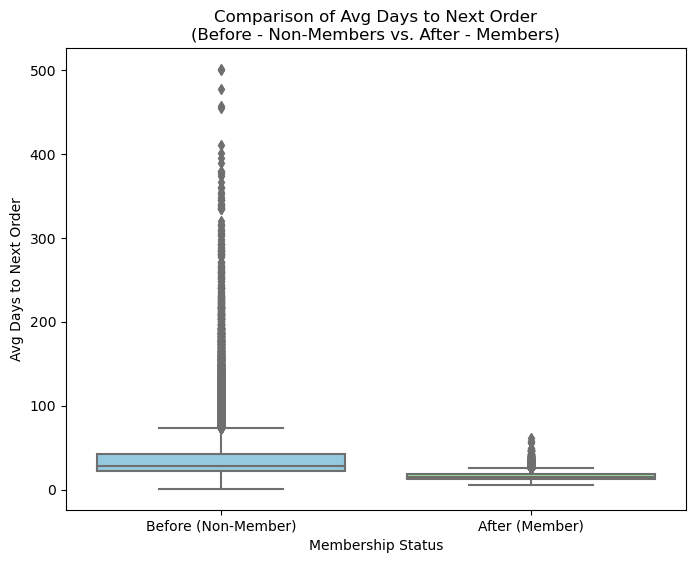

In [17]:
# Plot a box plot to compare 'BEF_AVG_DAYS_TO_NEXT_ORDER' and 'AFT_AVG_DAYS_TO_NEXT_ORDER'
plt.figure(figsize=(8, 6))
sns.boxplot(data=conv_Analysis_df[['BEF_AVG_DAYS_TO_NEXT_ORDER', 'AFT_AVG_DAYS_TO_NEXT_ORDER']], palette=['skyblue', 'lightgreen'])
plt.xlabel('Membership Status')
plt.ylabel('Avg Days to Next Order')
plt.title('Comparison of Avg Days to Next Order\n(Before - Non-Members vs. After - Members)')
plt.xticks(ticks=[0, 1], labels=['Before (Non-Member)', 'After (Member)'])
plt.show()



In [18]:
# Assuming conv_Analysis_df contains the data and columns 'BEF_AVG_DAYS_TO_NEXT_ORDER' and 'AFT_AVG_DAYS_TO_NEXT_ORDER'

conv_Analysis_df[['BEF_AVG_DAYS_TO_NEXT_ORDER', 'AFT_AVG_DAYS_TO_NEXT_ORDER','BEF_AVERAGE_SPENDING','AFT_AVERAGE_SPENDING']] = conv_Analysis_df[
    ['BEF_AVG_DAYS_TO_NEXT_ORDER', 'AFT_AVG_DAYS_TO_NEXT_ORDER','BEF_AVERAGE_SPENDING','AFT_AVERAGE_SPENDING']].astype('float32')


In [19]:
conv_Analysis_df[['BEF_AVG_DAYS_TO_NEXT_ORDER','AFT_AVG_DAYS_TO_NEXT_ORDER','BEF_AVERAGE_SPENDING','AFT_AVERAGE_SPENDING','BEF_NUM_OF_ORDERS','AFT_NUM_OF_ORDERS']].describe()

,BEF_AVG_DAYS_TO_NEXT_ORDER,AFT_AVG_DAYS_TO_NEXT_ORDER,BEF_AVERAGE_SPENDING,AFT_AVERAGE_SPENDING,BEF_NUM_OF_ORDERS,AFT_NUM_OF_ORDERS
count,33180.000000,33180.000000,33180.000000,33180.000000,33180.000000,33180.000000
mean,38.413441,16.139229,34.308617,39.740299,17.918264,34.343972
std,31.384535,4.710234,10.473816,5.840581,13.815220,14.796630
min,1.000000,5.222222,3.000000,7.333333,1.000000,2.000000
25%,21.822023,13.000000,28.937500,35.989361,6.000000,23.000000
50%,28.250000,15.297872,35.055557,39.514273,15.000000,34.000000
75%,42.602173,18.200001,40.227439,43.182199,28.000000,45.000000
max,502.000000,62.000000,141.000000,107.500000,74.000000,83.000000


## Year on Year Analysis

In [45]:
#Get unit profit
menu_profit=menu.with_column('UNIT_PROFIT',F.col('SALE_PRICE_USD')-F.col('COST_OF_GOODS_USD').cast('float'))
menu_profit=menu_profit.select(['MENU_ITEM_ID','UNIT_PROFIT'])

In [46]:
cust_Order = tasty_bytes_orders_v.filter(F.col('COUNTRY')=='United States')
memb_Order= loyal_customer_orders.filter(F.col('COUNTRY')=='United States')

#Merge to get loyal customers orders
cust_Order=cust_Order.join(
    right=menu_profit,
    on="MENU_ITEM_ID",
    how="inner"
)

#Get Profit
cust_Order=cust_Order.with_column('PROFIT',F.col('UNIT_PROFIT')*F.col('QUANTITY'))

#Get total sales
cust_Order =cust_Order.with_column('YEAR', F.year("ORDER_TS"))
cust_Order =cust_Order.with_column('MONTH',F.month("ORDER_TS"))
cust_sales_by_year=cust_Order.group_by('YEAR').agg(F.round(F.sum('PRICE'),2).alias('TOTAL_SALES'))
cust_sales_by_month=cust_Order.group_by(['YEAR','MONTH']).agg(F.round(F.sum('PRICE'),2).alias('TOTAL_SALES'))

In [47]:
#Get total profits
cust_profit_by_year=cust_Order.group_by('YEAR').agg(F.round(F.sum('PROFIT'),2).alias('TOTAL_PROFIT'))
cust_profit_by_month=cust_Order.group_by(['YEAR','MONTH']).agg(F.round(F.sum('PROFIT'),2).alias('TOTAL_PROFIT'))

In [48]:
#Get total orders
cust_orders_by_year=cust_Order.group_by('YEAR').agg(F.round(F.countDistinct('ORDER_ID'),2).alias('TOTAL_ORDERS'))
cust_orders_by_month=cust_Order.group_by(['YEAR','MONTH']).agg(F.round(F.countDistinct('ORDER_ID'),2).alias('TOTAL_ORDERS'))

In [49]:
#Get total sales
memb_Order=memb_Order.with_column('YEAR', F.year("ORDER_TS"))
memb_Order=memb_Order.with_column('MONTH',F.month("ORDER_TS"))
memb_sales_by_year=memb_Order.group_by('YEAR').agg(F.round(F.sum('PRICE'),2).alias('TOTAL_MEMBER_SALES'))
memb_sales_by_month=memb_Order.group_by(['YEAR','MONTH']).agg(F.round(F.sum('PRICE'),2).alias('TOTAL_MEMBER_SALES'))

In [50]:
#Get total orders
memb_orders_by_year=memb_Order.group_by('YEAR').agg(F.round(F.countDistinct('ORDER_ID'),2).alias('TOTAL_MEMBER_ORDERS'))
memb_orders_by_month=memb_Order.group_by(['YEAR','MONTH']).agg(F.round(F.countDistinct('ORDER_ID'),2).alias('TOTAL_MEMBER_ORDERS'))

In [51]:
memb_Sign_Up = memb_Order.dropDuplicates(['CUSTOMER_ID'])
memb_Sign_Up=memb_Sign_Up.with_column('SIGN_UP_YEAR', F.year('SIGN_UP_DATE'))
memb_Sign_Up=memb_Sign_Up.with_column('SIGN_UP_MONTH', F.month('SIGN_UP_DATE'))
memb_sign_up_by_year=memb_Sign_Up.group_by('SIGN_UP_YEAR').agg(F.round(F.count('CUSTOMER_ID'),2).alias('TOTAL_SIGN_UPS'))
memb_sign_up_by_year=memb_sign_up_by_year.withColumnRenamed(F.col('SIGN_UP_YEAR'),'YEAR')

In [52]:
memb_sign_up_by_month=memb_Sign_Up.group_by(['SIGN_UP_YEAR','SIGN_UP_MONTH']).agg(F.round(F.count('CUSTOMER_ID'),2).alias('TOTAL_SIGN_UPS'))
memb_sign_up_by_month=memb_sign_up_by_month.withColumnRenamed(F.col('SIGN_UP_YEAR'),'YEAR')
memb_sign_up_by_month=memb_sign_up_by_month.withColumnRenamed(F.col('SIGN_UP_MONTH'),'MONTH')

In [53]:
# cust_Sales=cust_Order.group_by(['YEAR','MONTH','CUSTOMER_ID']).agg(F.round(F.sum('ORDER_TOTAL'),2).alias('TOTAL_SALES'))

# cust_profit=cust_Order.group_by(['YEAR','MONTH','CUSTOMER_ID']).agg(F.round(F.sum('PROFIT'),2).alias('TOTAL_PROFIT'))

# cust_orders=cust_Order.group_by(['YEAR','MONTH','CUSTOMER_ID']).agg(F.round(F.count('ORDER_ID'),2).alias('TOTAL_ORDERS'))

# cust_Analysis=cust_Sales.join(
#     right=cust_profit,
#     on=['YEAR','MONTH','CUSTOMER_ID'],
#     how="inner"
# )
# cust_Analysis=cust_Analysis.join(
#     right=cust_orders,
#     on=['YEAR','MONTH','CUSTOMER_ID'],
#     how="inner"
# )

# cust_Analysis=cust_Analysis.sort(['YEAR','MONTH'])

# # Define a window partitioned by customer and menu item, ordered by date
# window_spec = Window.orderBy("YEAR")

# # Add a column with the date of the prior order for each customer 
# cust_Analysis= cust_Analysis.withColumn("PREVIOUS_YEAR_SALES_IN_MILLIONS", F.lag("TOTAL_SALES_IN_MILLIONS").over(window_spec))

# cust_Analysis=cust_Analysis.withColumn('YOY_SALES%',F.round(((F.col('TOTAL_SALES')-F.col("PREVIOUS_YEAR_SALES_IN_MILLIONS"))/ F.col("PREVIOUS_YEAR_SALES_IN_MILLIONS")) * 100,0))
# cust_Analysis=cust_Analysis.withColumn('MEMBER_SALES%',F.round((F.col('TOTAL_MEMBER_SALES_IN_MILLIONS')/F.col("TOTAL_SALES_IN_MILLIONS"))*100,2))

In [54]:
# #Merge to get loyal customers orders
# sales_Analysis_month=cust_sales_by_month.join(
#     right=memb_sales_by_month,
#     on=['YEAR','MONTH'],
#     how="inner"
# )
# sales_Analysis_month=sales_Analysis_month.join(
#     right=cust_orders_by_month,
#     on=['YEAR','MONTH'],
#     how="inner"
# )

# sales_Analysis_month=sales_Analysis_month.join(
#     right=memb_orders_by_month,
#     on=['YEAR','MONTH'],
#     how="inner"
# )

# sales_Analysis_month=sales_Analysis_month.join(
#     right=memb_sign_up_by_month,
#     on=['YEAR','MONTH'],
#     how="inner"
# )
# sales_Analysis_month=sales_Analysis_month.join(
#     right=cust_profit_by_month,
#     on=['YEAR','MONTH'],
#     how="inner"
# )

# sales_Analysis_month=sales_Analysis_month.sort(['YEAR','MONTH'])

In [55]:
#Merge to get loyal customers orders
sales_Analysis_year=cust_sales_by_year.join(
    right=memb_sales_by_year,
    on="YEAR",
    how="inner"
)
sales_Analysis_year=sales_Analysis_year.join(
    right=cust_orders_by_year,
    on="YEAR",
    how="inner"
)

sales_Analysis_year=sales_Analysis_year.join(
    right=memb_orders_by_year,
    on="YEAR",
    how="inner"
)

sales_Analysis_year=sales_Analysis_year.join(
    right=memb_sign_up_by_year,
    on="YEAR",
    how="inner"
)
sales_Analysis_year=sales_Analysis_year.join(
    right=cust_profit_by_year,
    on="YEAR",
    how="inner"
)

sales_Analysis_year=sales_Analysis_year.sort('YEAR')

In [56]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.orderBy("YEAR")

# Add a column with the date of the prior order for each customer 
sales_Analysis_year = sales_Analysis_year.withColumn("PREVIOUS_YEAR_SALES", F.lag("TOTAL_SALES").over(window_spec))

In [57]:
sales_Analysis_year=sales_Analysis_year.withColumn('YOY_SALES%',F.round(((F.col('TOTAL_SALES')-F.col("PREVIOUS_YEAR_SALES"))/ F.col("PREVIOUS_YEAR_SALES")) * 100,2))
sales_Analysis_year=sales_Analysis_year.withColumn('MEMBER_SALES%',F.round((F.col('TOTAL_MEMBER_SALES')/F.col("TOTAL_SALES"))*100,2))

In [58]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.orderBy("YEAR")

# Add a column with the date of the prior order for each customer 
sales_Analysis_year = sales_Analysis_year.withColumn("PREVIOUS_YEAR_SIGN_UPS", F.lag("TOTAL_SIGN_UPS").over(window_spec))

sales_Analysis_year=sales_Analysis_year.withColumn('YOY_MEMBER_GROWTH%',F.round(((F.col('TOTAL_SIGN_UPS')-F.col("PREVIOUS_YEAR_SIGN_UPS"))/ F.col("PREVIOUS_YEAR_SIGN_UPS")) * 100,2))

In [69]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.orderBy("YEAR")

# Add a column with the date of the prior order for each customer 
sales_Analysis_year = sales_Analysis_year.withColumn("PREVIOUS_MEMBER_SALES", F.lag("TOTAL_MEMBER_SALES").over(window_spec))

sales_Analysis_year=sales_Analysis_year.withColumn('YOY_MEMBER_SALES%',F.round(((F.col('TOTAL_MEMBER_SALES')-F.col("PREVIOUS_MEMBER_SALES"))/ F.col("PREVIOUS_MEMBER_SALES")) * 100,2))

In [60]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS")

unique_Order=cust_Order.dropDuplicates(['ORDER_ID'])
# Add a column with the date of the prior order for each customer and order
orders_df_pre = unique_Order.withColumn("DTNO", F.lead("ORDER_TS").over(window_spec))

orders_df = orders_df_pre.withColumn("DTNO", F.datediff(col1="ORDER_TS", col2="DTNO",part='day'))
orders_df = orders_df.na.drop(subset=["DTNO"])

orders_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"MENU_ITEM_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"  |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"E_MAIL"            

In [61]:
orders_df = orders_df.with_column("YEAR", F.year("ORDER_TS"))
orders_df = orders_df.with_column("MONTH", F.month("ORDER_TS"))
orders_df = orders_df.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

In [62]:
churn_YN = orders_df.with_column("CHURN", F.iff(F.col("DTNO") > 14, "1", "0"))
churn_YN.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"MENU_ITEM_ID"  |"DATE"      |"ORDER_ID"  |"TRUCK_ID"  |"ORDER_TS"           |"ORDER_DETAIL_ID"  |"LINE_NUMBER"  |"TRUCK_BRAND_NAME"  |"MENU_TYPE"     |"PRIMARY_CITY"  |"REGION"  |"COUNTRY"      |"FRANCHISE_FLAG"  |"FRANCHISE_ID"  |"FRANCHISEE_FIRST_NAME"  |"FRANCHISEE_LAST_NAME"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAM

In [68]:
churn_YN.group_by('YEAR').agg(F.sum('CHURN')).show()

-------------------------
|"YEAR"  |"SUM(CHURN)"  |
-------------------------
|2020    |318027.0      |
|2019    |60001.0       |
|2022    |320415.0      |
|2021    |409236.0      |
-------------------------



In [63]:
churn_rate=churn_YN.group_by('YEAR').agg(F.round((F.sum('CHURN')/F.count('ORDER_ID'))*100,2).alias('CHURN_RATE%'))

In [64]:
sales_Analysis_year=sales_Analysis_year.join(
    right=churn_rate,
    on="YEAR",
    how="inner"
)

In [70]:
sales_Analysis_year.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"YEAR"  |"TOTAL_SALES"  |"TOTAL_MEMBER_SALES"  |"TOTAL_ORDERS"  |"TOTAL_MEMBER_ORDERS"  |"TOTAL_SIGN_UPS"  |"TOTAL_PROFIT"  |"PREVIOUS_YEAR_SALES"  |"YOY_SALES%"  |"MEMBER_SALES%"  |"PREVIOUS_YEAR_SIGN_UPS"  |"YOY_MEMBER_GROWTH%"  |"CHURN_RATE%"  |"PREVIOUS_MEMBER_SALES"  |"YOY_MEMBER_SALES%"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2019    |8849707.00     |2194719.50            |274299          |72810                  |13184           

In [71]:
# sales_Analysis_year.to_pandas().to_csv('YoY_Analysis.csv',index=False)